In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import warnings

warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing/data.csv
/kaggle/input/marketing/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv
/kaggle/input/marketing/OnlineRetail.csv
/kaggle/input/marketing/WA_Fn-UseC_-Telco-Customer-Churn.csv


### 1) Calculating Key Metrics

The first thing to do when it comes to marketing analytics, is to always measure our north star metrics that best reflect the core value that our product delivers to customers.

* Monthly Revenue & Growth Rate
* Monthly Active Customers (MAU)
* Monthly Order Count
* Average Revenue Per User (ARPU)
* Average Revenue Per Order
* Monthly Retention Rate (MRR)

Lets write some functions to compute and visualize them!

In [2]:
df = pd.read_csv('/kaggle/input/marketing/OnlineRetail.csv', encoding='cp1252')
df.InvoiceDate = pd.to_datetime(df.InvoiceDate).dt.to_period('m')
print(len(df))
df.head()

541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12,3.39,17850.0,United Kingdom


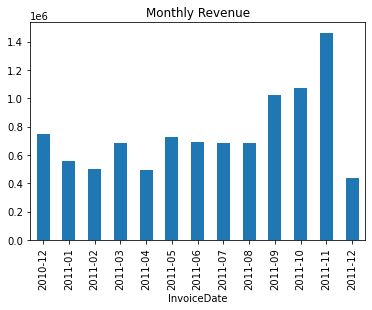

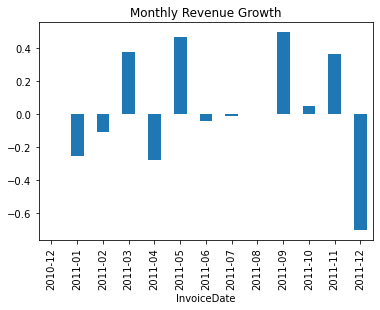

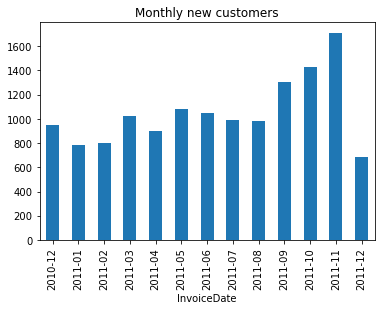

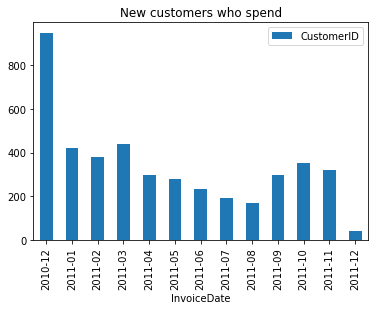

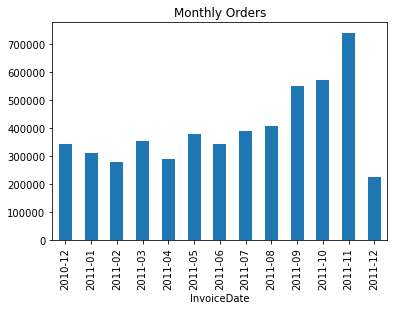

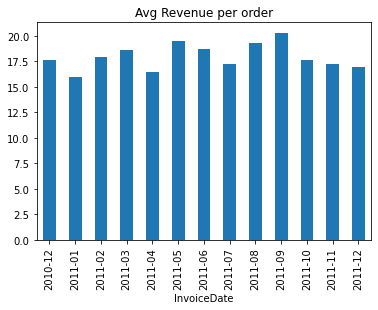

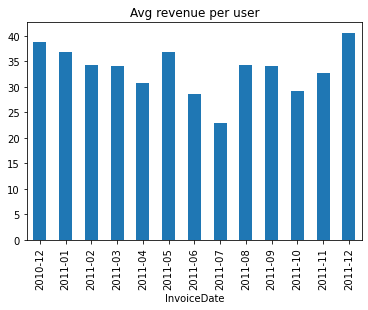

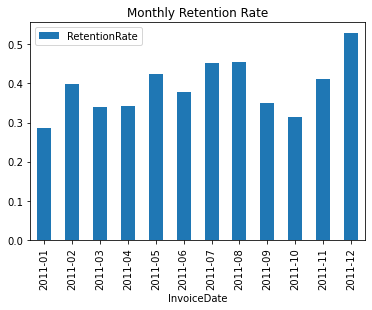

In [10]:
def monthly_retention_rate(df):
    # customers who made orders in the month, and also the previous month
    df2 = df.groupby(['CustomerID', 'InvoiceDate']).Revenue.sum().reset_index()
    retention = pd.crosstab(df2['CustomerID'], df2['InvoiceDate'])
    arr, periods = [], list(retention.columns)
    for i, period in enumerate(periods[1:]):
        data, prev = {'InvoiceDate': period}, periods[i-1]
        total_users = retention[period].sum()
        retained_users = retention[(retention[period] > 0) & (retention[prev] > 0)][period].sum()
        data['RetentionRate'] = retained_users / total_users
        arr.append(data)

    return pd.DataFrame(arr).set_index('InvoiceDate')

def plot_metrics(df):
    df['Revenue'] = df.Quantity * df.UnitPrice
    grouped_date = df.groupby('InvoiceDate')
    revenue = grouped_date.Revenue.sum()
    customers = df.groupby('CustomerID').InvoiceDate.min().reset_index().set_index('InvoiceDate')
    avg_rev = df.groupby(['InvoiceDate', 'CustomerID']).Revenue.mean()
    metrics = {
        'Monthly Revenue': revenue,
        'Monthly Revenue Growth': revenue.pct_change(),
        'Monthly new customers': grouped_date.CustomerID.nunique(),
        'New customers who spend': customers.groupby('InvoiceDate').count(),
        'Monthly Orders': grouped_date.Quantity.sum(),
        'Avg Revenue per order': grouped_date.Revenue.mean(),
        'Avg revenue per user': avg_rev.groupby('InvoiceDate').mean(),
        'Monthly Retention Rate': monthly_retention_rate(df)
    }
    for title, metric in metrics.items():
        metric.plot.bar(title=title)
        plt.show()

plot_metrics(df)

### 2) Estimating Customer Lifetime Value

CLTV = freq of spending x avg amount per spend x time before churn 

For each customer, calculate:
- how frequent do they spend?
- how much do they spend on average per purchase?
- what is the average time customers spend before dropping off?

In [11]:
# average amount spent, and total number of times spent
df = pd.read_csv('/kaggle/input/marketing/OnlineRetail.csv', encoding='cp1252')
df.InvoiceDate = pd.to_datetime(df.InvoiceDate).dt.date
df['Revenue'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [12]:
# sum of spending per invoice, get mean of each invoice, and min/max invoice dates
df_agg = df.groupby(['CustomerID', 'InvoiceNo']).sum()
df_agg = df_agg.groupby('CustomerID').agg({'Revenue': ['mean', 'count']})
df_agg = df_agg.merge(df.groupby(['CustomerID']).agg({'InvoiceDate': ['min', 'max']}), on='CustomerID')
df_agg.head()

Revenue       InvoiceDate            
                   mean count         min         max
CustomerID                                           
12346.0        0.000000     2  2011-01-18  2011-01-18
12347.0      615.714286     7  2010-12-07  2011-12-07
12348.0      449.310000     4  2010-12-16  2011-09-25
12349.0     1757.550000     1  2011-11-21  2011-11-21
12350.0      334.400000     1  2011-02-02  2011-02-02

In [13]:
from operator import attrgetter

df_agg['active_days'] = (df_agg.InvoiceDate['max'] - df_agg.InvoiceDate['min']).dt.days + 1
df_agg['total_spend'] = df_agg.Revenue['mean'] * df_agg.Revenue['count']
df_agg['avg_daily_spend'] = df_agg['total_spend'] / df_agg['active_days']
df_agg['avg_days_between_spend'] = df_agg['active_days'] / df_agg.Revenue['count']
avg_lifetime = df_agg.active_days.mean() # average life time of a customer is ~134 days or 4.5 months 
df_agg['CLTV'] = avg_lifetime * df_agg.avg_daily_spend
df_agg.head()

Revenue       InvoiceDate             active_days total_spend  \
                   mean count         min         max                           
CustomerID                                                                      
12346.0        0.000000     2  2011-01-18  2011-01-18           1        0.00   
12347.0      615.714286     7  2010-12-07  2011-12-07         366     4310.00   
12348.0      449.310000     4  2010-12-16  2011-09-25         284     1797.24   
12349.0     1757.550000     1  2011-11-21  2011-11-21           1     1757.55   
12350.0      334.400000     1  2011-02-02  2011-02-02           1      334.40   

           avg_daily_spend avg_days_between_spend           CLTV  
                                                                  
CustomerID                                                        
12346.0           0.000000               0.500000       0.000000  
12347.0          11.775956              52.285714    1586.492277  
12348.0           6.328310              71.000000     852.568953  
12349.0        1757.550000               1.000000  236782.426338  
12350.0         334.400000               1.000000   45051.374565

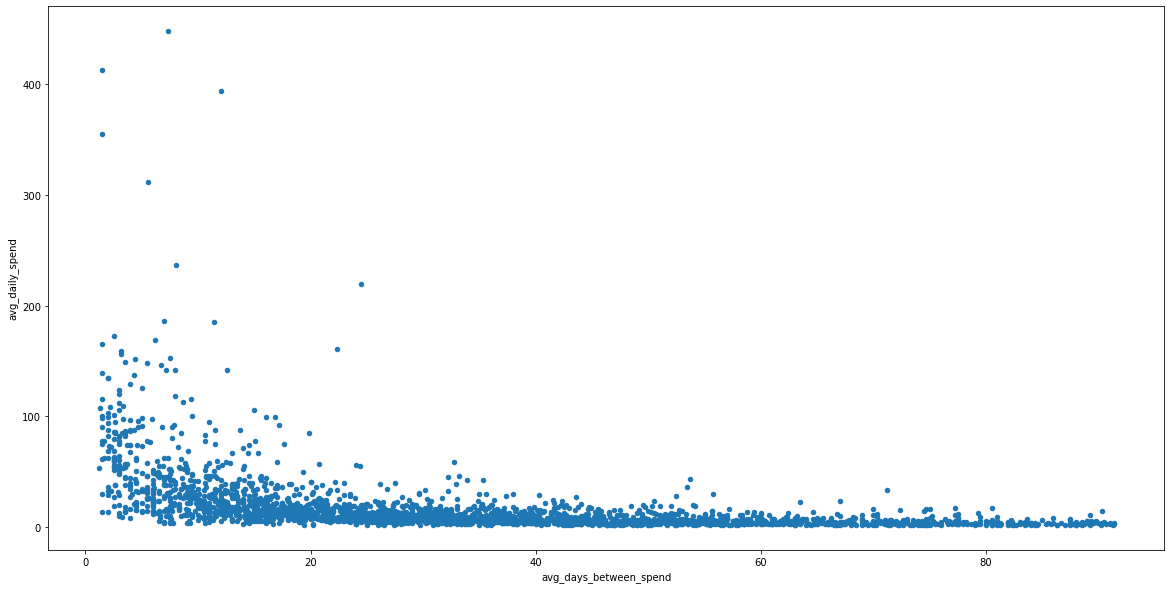

In [14]:
# Customers who have the lowest avg days between spend and spend the most daily have highest CLTV, these are the ones we want
q1 = df_agg < df_agg.quantile(0.95)
q2 = df_agg.quantile(0.05) < df_agg
df_agg[q1][q2].plot(x='avg_days_between_spend', y='avg_daily_spend', kind='scatter', figsize=(20, 10))

### 3) Customer Segmentation 

Given a dataset about customer info, we want to answer the questions:
* What are our various types of customer personas?
* Which customers should we focus on to drive revenue growth?
* Which customers should we avoid?

Approach:
- One-Hot-Encode - state, response, coverage, education, employment, gender, policy type, policy, renew offer type, sales channel, vehicle class, vehicle size
- Apply standard scaler to numeric columns
- Drop redundant columns
- Apply PCA


To do so, we will be exploring 3 unsupervised learning models - KMEANs, DBScan and TSNE

In [25]:
df_seg = pd.read_csv('/kaggle/input/marketing/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
print(df_seg.Customer.nunique())
print(df_seg.columns)
df_seg.head()

9134
Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')


,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [26]:
cols_to_cat = ['State','Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Policy',
               'Location Code', 'Marital Status','Policy Type', 'Renew Offer Type', 'Sales Channel',
               'Vehicle Class', 'Vehicle Size']

df_cat = df_seg[cols_to_cat]
df_seg = df_seg.drop(cols_to_cat + ['Effective To Date', 'Customer'], axis=1)
cols_to_scale = list(df_seg.columns)
for col in cols_to_cat:
    df_seg = pd.concat([df_seg, pd.get_dummies(df_cat[col])], axis=1)
df_scaled = df_seg
df_scaled[cols_to_scale] = MinMaxScaler().fit_transform(df_scaled[cols_to_scale])
df_scaled

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Arizona,California,...,Web,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car,Large,Medsize,Small
0,0.010629,0.562847,0.033755,0.914286,0.050505,0.0,0.000,0.132974,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.062406,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.391051,1,0,...,0,1,0,0,0,0,0,0,1,0
2,0.134960,0.487763,0.198312,0.514286,0.383838,0.0,0.125,0.195764,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0.070589,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.183117,0,1,...,0,0,0,0,1,0,0,0,1,0
4,0.011245,0.438443,0.050633,0.342857,0.444444,0.0,0.000,0.047710,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,0.264137,0.719547,0.050633,0.514286,0.898990,0.0,0.125,0.068485,0,1,...,1,1,0,0,0,0,0,0,1,0
9130,0.014719,0.216081,0.075949,0.400000,0.282828,0.0,0.000,0.131034,0,1,...,0,1,0,0,0,0,0,0,1,0
9131,0.076951,0.000000,0.101266,0.257143,0.373737,0.6,0.125,0.273297,0,1,...,0,1,0,0,0,0,0,0,1,0
9132,0.069098,0.219452,0.147679,0.971429,0.030303,0.0,0.250,0.238876,0,1,...,0,1,0,0,0,0,0,1,0,0


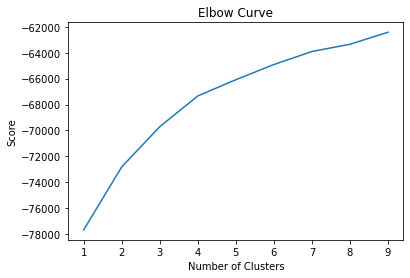

In [27]:
# The elbow isnt very obvious, but seems like there are 4-5 distinct clusters
models = [KMeans(n_clusters=i) for i in range(1, 10)]
score = [models[i].fit(df_scaled).score(df_scaled) for i in range(len(models))]

plt.plot(range(1, 10), score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show()

In [28]:
# by clustering we can visualize the various clusters
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_scaled)
# print(df_scaled.cluster.value_counts())
cols = df_scaled.columns
print(cols)
df_scaled['cluster'] = kmeans.predict(df_scaled)
df_scaled.head()

Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'Arizona', 'California', 'Nevada', 'Oregon', 'Washington', 'No', 'Yes',
       'Basic', 'Extended', 'Premium', 'Bachelor', 'College', 'Doctor',
       'High School or Below', 'Master', 'Disabled', 'Employed',
       'Medical Leave', 'Retired', 'Unemployed', 'F', 'M', 'Corporate L1',
       'Corporate L2', 'Corporate L3', 'Personal L1', 'Personal L2',
       'Personal L3', 'Special L1', 'Special L2', 'Special L3', 'Rural',
       'Suburban', 'Urban', 'Divorced', 'Married', 'Single', 'Corporate Auto',
       'Personal Auto', 'Special Auto', 'Offer1', 'Offer2', 'Offer3', 'Offer4',
       'Agent', 'Branch', 'Call Center', 'Web', 'Four-Door Car', 'Luxury Car',
       'Luxury SUV', 'SUV', 'Sports Car', 'Two-Door Car', 'Large', 'Medsize',
       'Small'],
      dtype='object

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Arizona,California,...,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car,Large,Medsize,Small,cluster
0,0.010629,0.562847,0.033755,0.914286,0.050505,0.0,0.000,0.132974,0,0,...,0,0,0,0,0,1,0,1,0,2
1,0.062406,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.391051,1,0,...,1,0,0,0,0,0,0,1,0,1
2,0.134960,0.487763,0.198312,0.514286,0.383838,0.0,0.125,0.195764,0,0,...,0,0,0,0,0,1,0,1,0,3
3,0.070589,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.183117,0,1,...,0,0,0,1,0,0,0,1,0,2
4,0.011245,0.438443,0.050633,0.342857,0.444444,0.0,0.000,0.047710,0,0,...,1,0,0,0,0,0,0,1,0,0


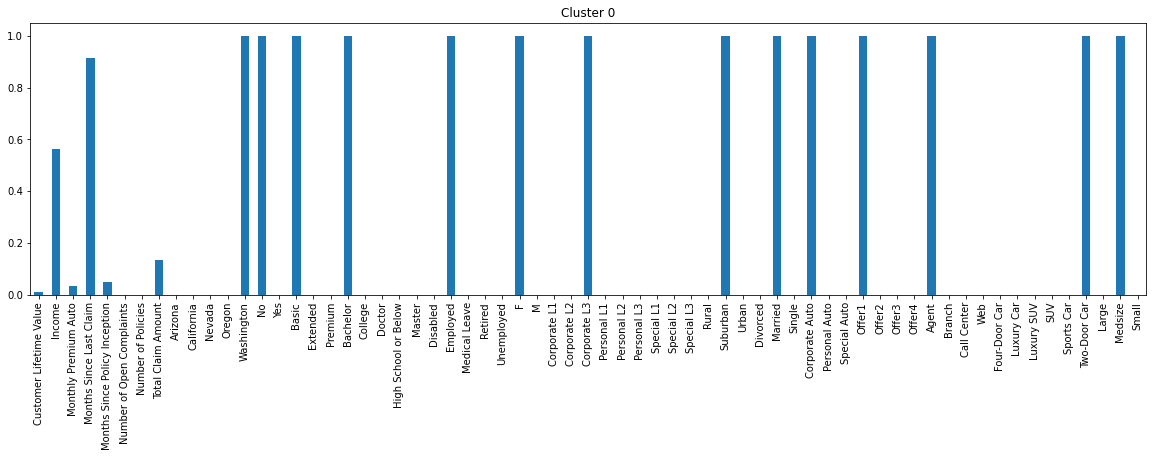

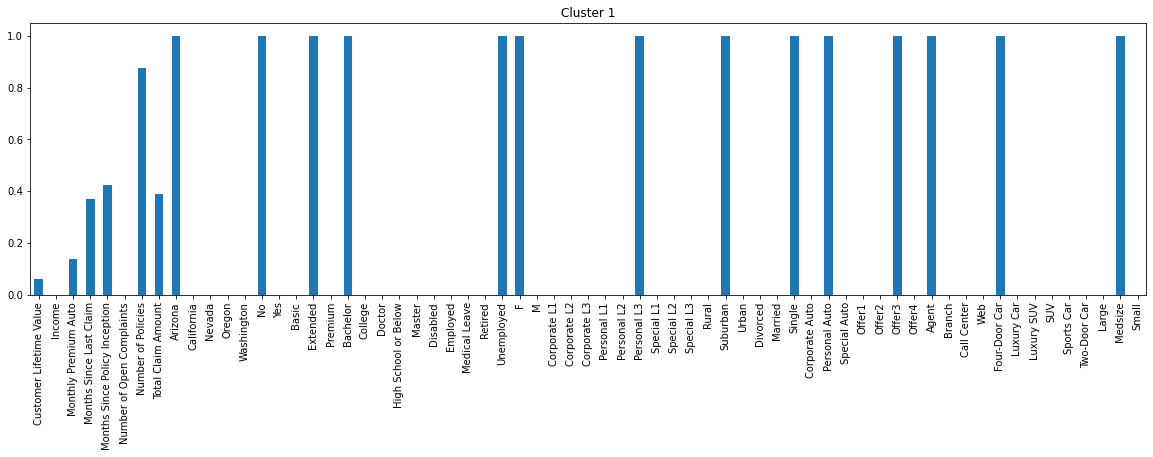

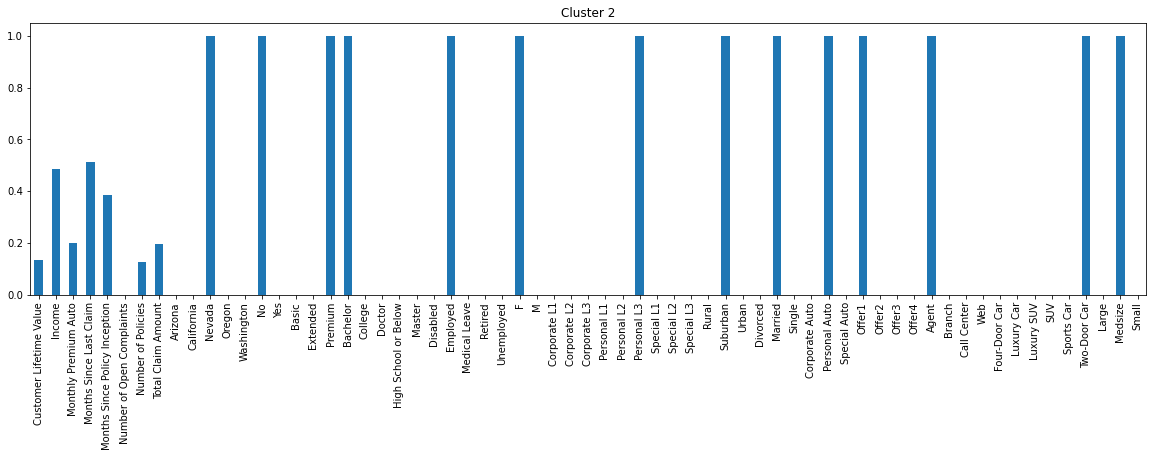

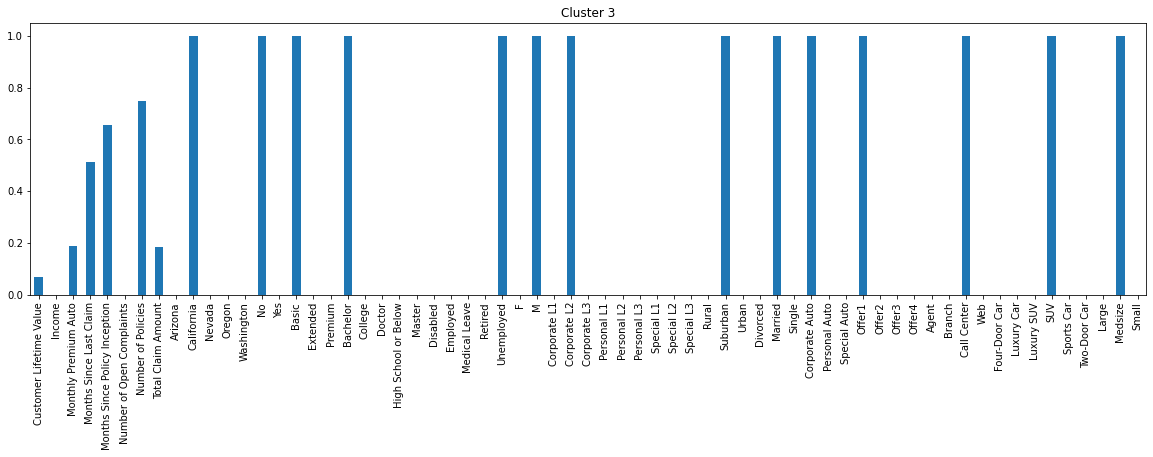

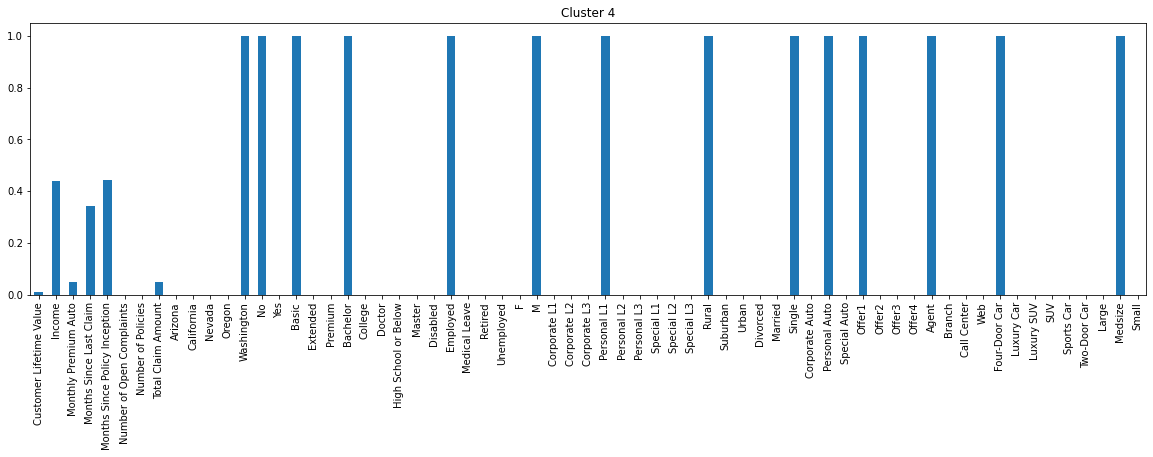

In [19]:
# Visualize clusters
df_scaled = df_scaled.drop(['cluster'], axis=1)
for i in range(5):
    df_scaled.iloc[i].plot(title='Cluster '+str(i), kind='bar', figsize=(20, 5))
    plt.show()

In [20]:
for i in range(5):
    print('\nCluster {}: '.format(i) + ','.join(df_scaled.iloc[i][df_scaled.iloc[i] > 0.5].index))


Cluster 0: Income,Months Since Last Claim,Washington,No,Basic,Bachelor,Employed,F,Corporate L3,Suburban,Married,Corporate Auto,Offer1,Agent,Two-Door Car,Medsize

Cluster 1: Number of Policies,Arizona,No,Extended,Bachelor,Unemployed,F,Personal L3,Suburban,Single,Personal Auto,Offer3,Agent,Four-Door Car,Medsize

Cluster 2: Months Since Last Claim,Nevada,No,Premium,Bachelor,Employed,F,Personal L3,Suburban,Married,Personal Auto,Offer1,Agent,Two-Door Car,Medsize

Cluster 3: Months Since Last Claim,Months Since Policy Inception,Number of Policies,California,No,Basic,Bachelor,Unemployed,M,Corporate L2,Suburban,Married,Corporate Auto,Offer1,Call Center,SUV,Medsize

Cluster 4: Washington,No,Basic,Bachelor,Employed,M,Personal L1,Rural,Single,Personal Auto,Offer1,Agent,Four-Door Car,Medsize


Plotting a normalized stacked bar chart of our classes, we observe the following about each of the classes:
* Class 0: High Income, most complaints, mostly men
* Class 1: People who are low income, unemployed, single, claim the most, most fit, least educated, suburban
* Class 2: High Income, corporate insurance 
* Class 3: Mainly females, highest CLTV, high income
* Class 4: Retirees with good savings, most educated, disabled, highest divorced

In [29]:
df_scaled

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Arizona,California,...,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car,Large,Medsize,Small,cluster
0,0.010629,0.562847,0.033755,0.914286,0.050505,0.0,0.000,0.132974,0,0,...,0,0,0,0,0,1,0,1,0,2
1,0.062406,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.391051,1,0,...,1,0,0,0,0,0,0,1,0,1
2,0.134960,0.487763,0.198312,0.514286,0.383838,0.0,0.125,0.195764,0,0,...,0,0,0,0,0,1,0,1,0,3
3,0.070589,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.183117,0,1,...,0,0,0,1,0,0,0,1,0,2
4,0.011245,0.438443,0.050633,0.342857,0.444444,0.0,0.000,0.047710,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,0.264137,0.719547,0.050633,0.514286,0.898990,0.0,0.125,0.068485,0,1,...,1,0,0,0,0,0,0,1,0,0
9130,0.014719,0.216081,0.075949,0.400000,0.282828,0.0,0.000,0.131034,0,1,...,1,0,0,0,0,0,0,1,0,2
9131,0.076951,0.000000,0.101266,0.257143,0.373737,0.6,0.125,0.273297,0,1,...,1,0,0,0,0,0,0,1,0,1
9132,0.069098,0.219452,0.147679,0.971429,0.030303,0.0,0.250,0.238876,0,1,...,1,0,0,0,0,0,1,0,0,0


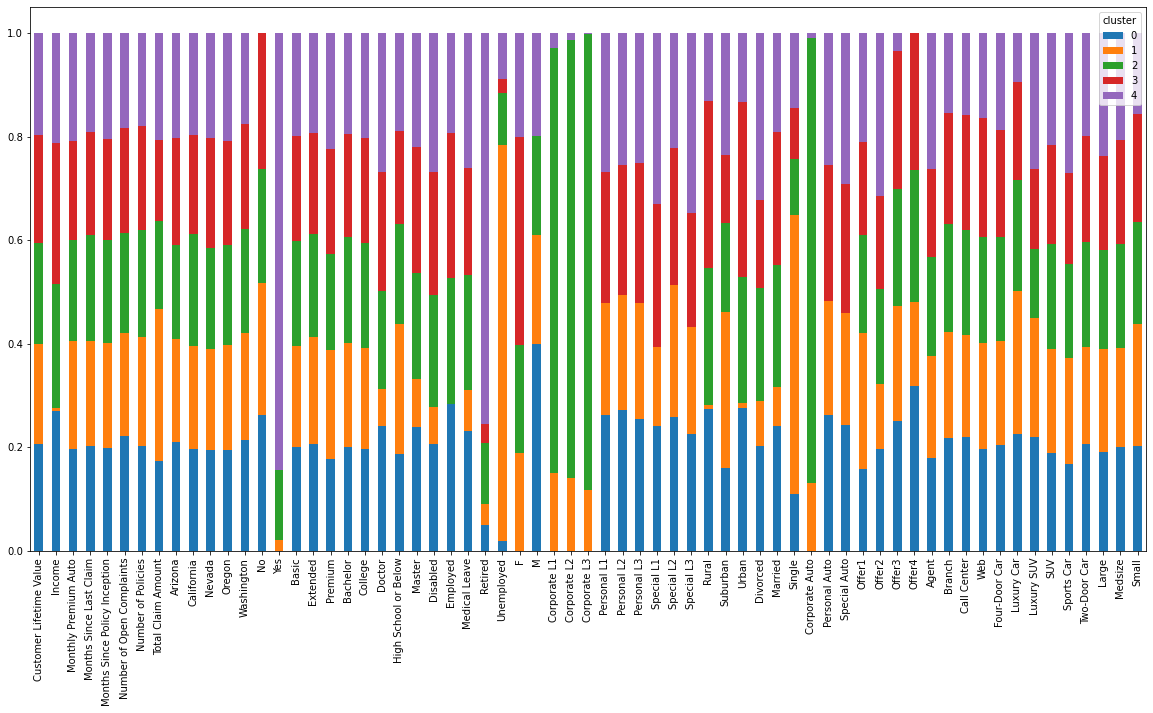

In [30]:
data = df_scaled.groupby('cluster').mean()
data = data.div(data.sum(), axis=1)
data.T.plot.bar(stacked=True, figsize=(20, 10))

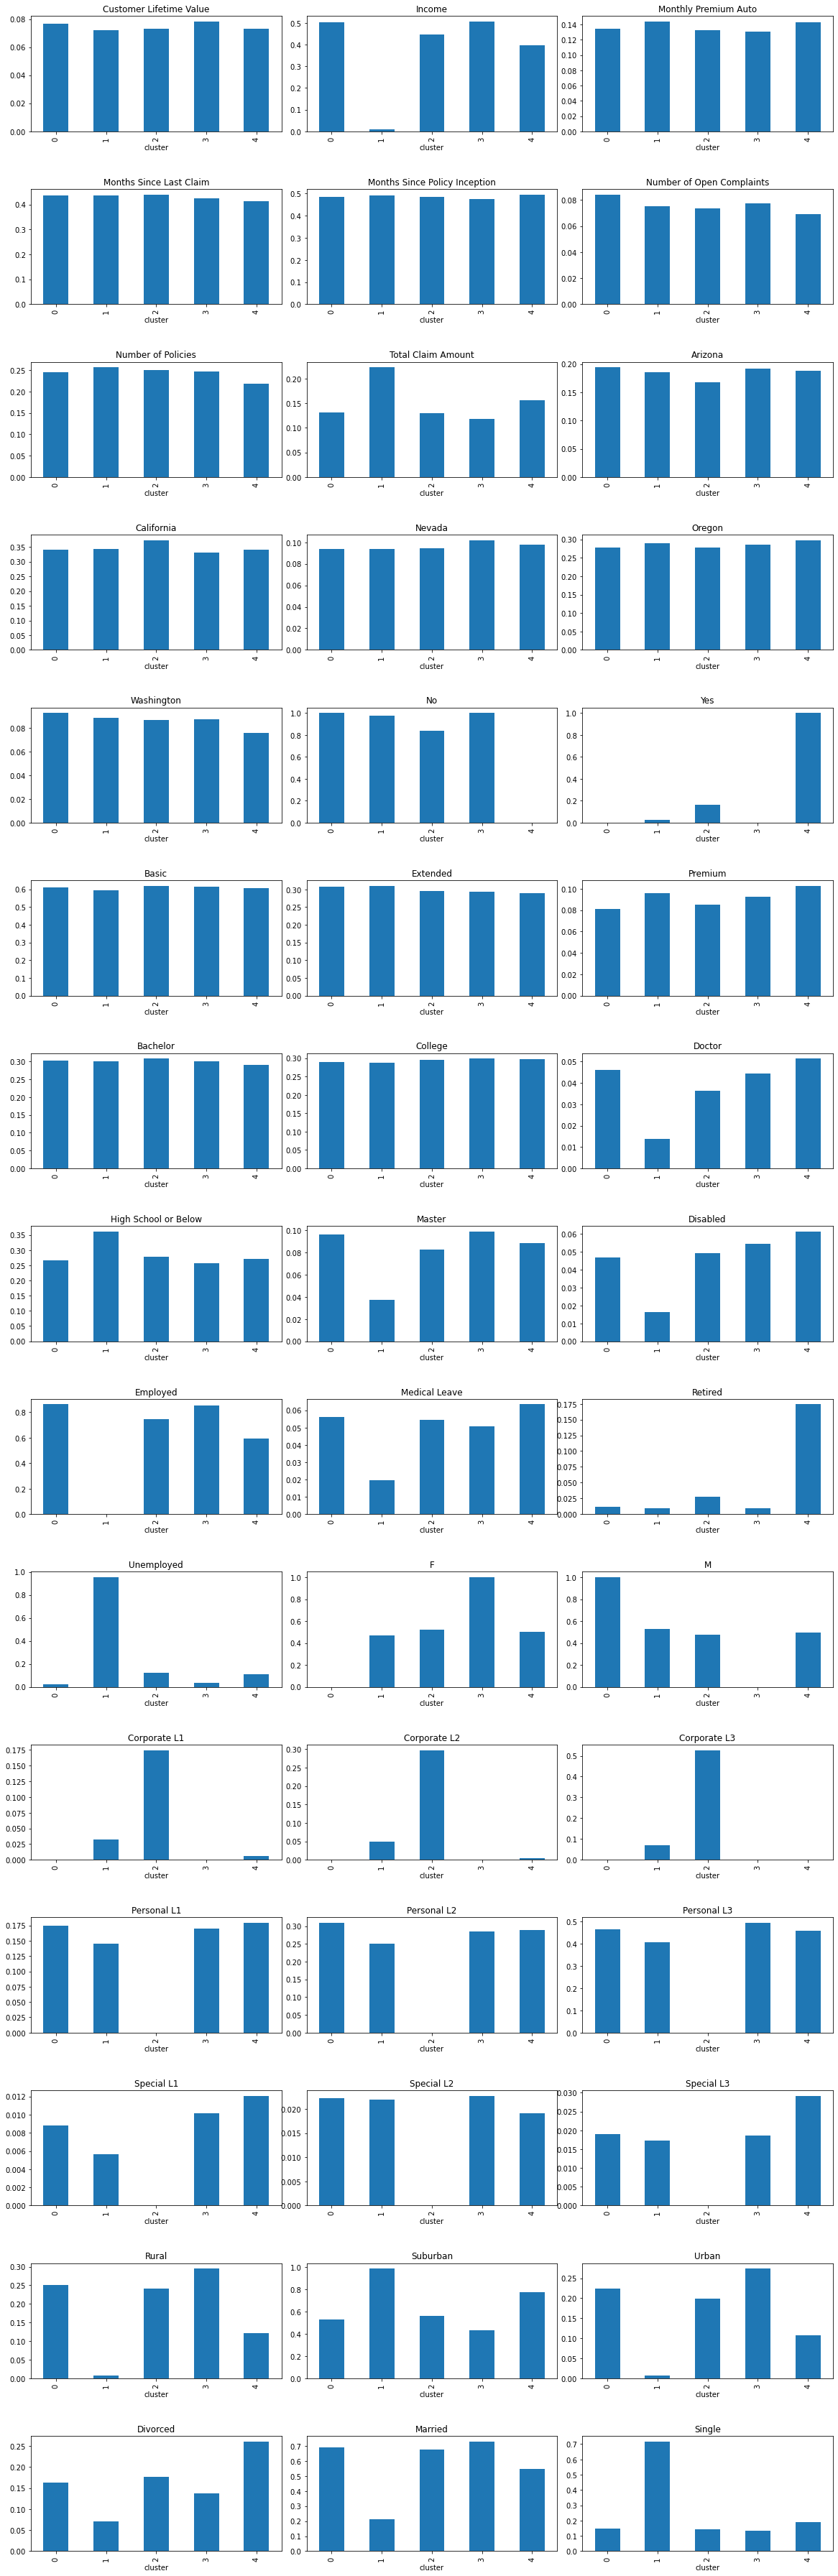

In [31]:
d = df_scaled.groupby('cluster').mean()
fig, ax = plt.subplots(15, 3)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
i = 0
for r in range(15):
    for c in range(3):
        d.iloc[:,i].plot.bar(title=d.columns[i], ax=ax[r, c], figsize=(20, 50))
        i += 1

### DB SCAN

- Describe how it works?

In [22]:
db = DBSCAN(eps=0.5, min_samples=20, n_jobs=-1).fit(df_scaled)
pred_labels = db.labels_
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0) # Count the total number of clusters
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 0


TSNE 

- Describe how it works?

In [23]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(df_scaled)
plt.scatter(tsne_results[:, 0],tsne_results[:, 1])
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9134 samples in 0.178s...
[t-SNE] Computed neighbors for 9134 samples in 14.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9134
[t-SNE] Computed conditional probabilities for sample 2000 / 9134
[t-SNE] Computed conditional probabilities for sample 3000 / 9134
[t-SNE] Computed conditional probabilities for sample 4000 / 9134
[t-SNE] Computed conditional probabilities for sample 5000 / 9134
[t-SNE] Computed conditional probabilities for sample 6000 / 9134
[t-SNE] Computed conditional probabilities for sample 7000 / 9134
[t-SNE] Computed conditional probabilities for sample 8000 / 9134
[t-SNE] Computed conditional probabilities for sample 9000 / 9134
[t-SNE] Computed conditional probabilities for sample 9134 / 9134
[t-SNE] Mean sigma: 0.994806
[t-SNE] KL divergence after 50 iterations with early exaggeration: 96.335678


KeyboardInterrupt: 

### 4) Churn Prediction

In [4]:
df_telco = pd.read_csv('/kaggle/input/marketing/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df_telco.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
from category_encoders.count import CountEncoder

cols_to_cat = ['gender', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
               'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
df_telco[cols_to_cat] = CountEncoder().fit_transform(df_telco[cols_to_cat])
df_telco = df_telco.drop(['customerID'], axis=1)
df_telco.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3488,0,3402,4933,1,682,682,2421,3498,2429,3095,3473,2810,2785,3875,4171,2365,29.85,29.85,5174
1,3555,0,3641,4933,34,6361,3390,2421,2019,3088,2422,3473,2810,2785,1473,2872,1612,56.95,1889.5,5174
2,3555,0,3641,4933,2,6361,3390,2421,2019,2429,3095,3473,2810,2785,3875,4171,1612,53.85,108.15,1869
3,3555,0,3641,4933,45,682,682,2421,2019,3088,2422,2044,2810,2785,1473,2872,1544,42.30,1840.75,5174
4,3488,0,3641,4933,2,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,70.70,151.65,1869


Plotting the correlation matrix, we observe that
- monthly charges are highly correlated with the type of internet service, and also streaming TV and movies
- phone service and multiple lines are highly correlated
- churn is inversely correlated with having a contract, certain payment methods, online security and moderate correlation with tenure

In [48]:
### Plot Correlation matrix
df_telco.iloc[:, 8:].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
OnlineSecurity,1.00,0.66,0.66,0.62,0.68,0.68,0.39,0.30,0.35,0.49,0.03,-0.35
OnlineBackup,0.66,1.00,0.81,0.67,0.88,0.88,0.31,0.28,0.29,0.59,0.14,-0.29
DeviceProtection,0.66,0.81,1.00,0.69,0.88,0.88,0.35,0.29,0.30,0.56,0.13,-0.28
TechSupport,0.62,0.67,0.69,1.00,0.70,0.70,0.41,0.28,0.35,0.47,0.02,-0.34
StreamingTV,0.68,0.88,0.88,0.70,1.00,1.00,0.23,0.31,0.26,0.73,0.34,-0.23
StreamingMovies,0.68,0.88,0.88,0.70,1.00,1.00,0.22,0.32,0.26,0.75,0.36,-0.23
Contract,0.39,0.31,0.35,0.41,0.23,0.22,1.00,0.17,0.34,0.06,-0.44,-0.40
PaperlessBilling,0.30,0.28,0.29,0.28,0.31,0.32,0.17,1.00,0.20,0.35,0.16,-0.19
PaymentMethod,0.35,0.29,0.30,0.35,0.26,0.26,0.34,0.20,1.00,0.25,-0.09,-0.30
MonthlyCharges,0.49,0.59,0.56,0.47,0.73,0.75,0.06,0.35,0.25,1.00,0.65,-0.19


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def to_float(x):
    try:
        result = float(x)
        return result
    except:
        return 0
        
# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

models = [clf1, clf2, clf3, eclf]
names = ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble']

df_telco.TotalCharges = df_telco.TotalCharges.fillna(0).apply(lambda x: to_float(x))
y = df_telco.Churn
X = df_telco.drop(['Churn'], axis=1)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3)
for model, name in zip(models, names):
    model.fit(trainX, trainY)
    score = model.score(testX, testY)
    print(name, ': ' , score)


Logistic Regression :  0.7927117841930904
Random Forest :  0.7832465688594415
RBF kernel SVM :  0.7841930903928065
Ensemble :  0.8012304779933743


### Uplift Modelling

Imagine a case that you are about to launch a promotional campaign and you know which segment you want to target. Do you need to send the offer to everyone? The answer is no. In your current target group, there will be customers who are going to purchase anyways. You will cannibalize yourself by giving the promotion. We can summarize the segments based on this approach like below:

* Treatment Responders: Customers that will purchase only if they receive an offer
* Treatment Non-Responders: Customer that won’t purchase in any case
* Control Responders: Customers that will purchase without an offer
* Control Non-Responders: Customers that will not purchase if they don’t receive an offer

The picture is very obvious. You need to target Treatment Responders (TR) and Control Non-Responders (CN). Since they won’t purchase unless you give an offer, these groups are boosting your uplift in promotional campaigns. 

On the other hand, you need to avoid targeting Treatment Non-Responders (TN) and Control Responders (CR). You will not benefit from targeting TN and, CN will make you cannibalize.

There is one last simple thing to do. We need to identify which customers fall into which buckets. The answer is Uplift Modeling. It has two simple steps:

1. Predict the probabilities of being in each group for all customers: we are going to build a multi-classification model for that.

2. We will calculate the uplift score by summing up the probability of being TR and CN and subtract the probability of falling into other buckets. The higher score means higher uplift.

In [60]:
df_uplift = pd.read_csv('/kaggle/input/marketing/data.csv')
df_uplift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


First off, we need to build a function that calculates our uplift. To keep it simple, we will assume every conversion means 1 order and the average order value is $25. We are going to calculate three types of uplift:

* Conversion Uplift: Conversion rate of test - control group
* Order Uplift: Conversion uplift x converted customers in test group
* Revenue Uplift: Order Uplift x Average order $ value

Discount looks like a better option if we want to get more conversion. It brings 7.6% uptick compared to the customers who didn’t receive any offer. BOGO (Buy One Get One) has 4.5% uptick as well.

In [61]:
def calc_uplift(df):
    avg_order_value = 25 #assigning 25$ to the average order value
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
          
    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))
    
calc_uplift(df_uplift)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


In [62]:
df_uplift['campaign_group'] = 1 # 'treatment'
df_uplift.loc[df_uplift.offer == 'No Offer', 'campaign_group'] = 0 # 'control'
df_uplift['target_class'] = 0 #CN
df_uplift.loc[(df_uplift.campaign_group == 0) & (df_uplift.conversion > 0),'target_class'] = 1 #CR
df_uplift.loc[(df_uplift.campaign_group == 1) & (df_uplift.conversion == 0),'target_class'] = 2 #TN
df_uplift.loc[(df_uplift.campaign_group == 1) & (df_uplift.conversion > 0),'target_class'] = 3 #TR
df_uplift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,1,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,1,2
3,9,675.83,1,0,Rural,1,Web,Discount,0,1,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0,1,2
63996,5,38.91,0,1,Urban,1,Phone,Discount,0,1,2
63997,6,29.99,1,0,Urban,1,Phone,Discount,0,1,2
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0,1,2


In [63]:
#creating the clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_uplift[['history']])
df_uplift['history_cluster'] = kmeans.predict(df_uplift[['history']])#order the clusters
df_uplift = order_cluster('history_cluster', 'history',df_uplift,True)#creating a new dataframe as model and dropping columns that defines the label
df_model = df_uplift.drop(['offer','campaign_group','conversion'],axis=1)#convert categorical columns
df_model = pd.get_dummies(df_model)
df_model

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,2,1399.97,1,1,1,1,4,0,1,0,0,1,0
63996,1,1584.31,1,0,1,2,4,0,1,0,1,0,0
63997,1,1252.19,1,0,1,3,4,0,0,1,0,1,0
63998,2,1183.05,1,1,1,0,4,1,0,0,0,1,0


In [64]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)#fitting the model and predicting the probabilities
xgb_model = XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)
class_probs

array([[0.34225672, 0.02629696, 0.5742023 , 0.05724405],
       [0.25583565, 0.05858655, 0.51495504, 0.17062272],
       [0.34232002, 0.03979245, 0.53343856, 0.08444896],
       ...,
       [0.40199432, 0.01509759, 0.52423406, 0.05867404],
       [0.30752268, 0.03263684, 0.5564864 , 0.10335402],
       [0.429918  , 0.02494676, 0.42489392, 0.12024129]], dtype=float32)

In [66]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')#assign it back to main dataframe
df_uplift['uplift_score'] = df_model['uplift_score']
df_uplift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,1,2,0,-0.190610
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,1,2,0,-0.078211
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,1,3,0,-0.119157
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,1,2,0,-0.211866
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,1,2,0,-0.532395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,2,1399.97,1,1,Surburban,1,Phone,No Offer,1,0,1,4,-0.153770
63996,1,1584.31,1,0,Surburban,1,Multichannel,Discount,0,1,2,4,-0.462533
63997,1,1252.19,1,0,Urban,1,Phone,Buy One Get One,1,1,3,4,-0.735811
63998,2,1183.05,1,1,Rural,1,Phone,No Offer,0,0,0,4,0.370560


To evaluate our model, we will create two different groups and compare them with our benchmark. Groups are:

1- High Uplift Score: Customers have uplift score > 3rd quantile

2- Low Uplift Score: Customers have uplift score < 2nd quantile

We are going to compare:

Conversion uplift
Revenue uplift per target customer to see if our model can make our actions more efficient.

The results are great. It shows that we can double our uplift score just by targeting those 

In [71]:
df_data_lift = df_uplift.copy()[df_uplift.uplift_score > 0]
#uplift_q_75 = df_data_lift.uplift_score.quantile(0.5)
#df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True) #calculate the uplift
calc_uplift(df_data_lift)

Discount Conversion Uplift: 53.61%
Discount Order Uplift: 567.19
Discount Revenue Uplift: $14179.71

-------------- 

BOGO Conversion Uplift: 51.86%
BOGO Order Uplift: 516.52
BOGO Revenue Uplift: $12912.94


In [ ]:
df_uplift.uplift_score.plot(figsize=(20, 5), kind='bar')

### A/B Testing

In [4]:
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index < 10000,'group'] = 'test'
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.5, 10000)
df_hv.head(10)

,customer_id,segment,group,purchase_count
0,0,high-value,test,2.0
1,1,high-value,test,1.0
2,2,high-value,test,1.0
3,3,high-value,test,2.0
4,4,high-value,test,0.0
5,5,high-value,test,0.0
6,6,high-value,test,0.0
7,7,high-value,test,2.0
8,8,high-value,test,0.0
9,9,high-value,test,1.0


In [9]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as pyoff

test_results = df_hv[df_hv.group == 'test'].purchase_count
control_results = df_hv[df_hv.group == 'control'].purchase_count

hist_data = [test_results, control_results]
group_labels = ['test', 'control']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.5, curve_type='normal',show_rug=False)
fig.layout = go.Layout(
        title='High Value Customers Test vs Control',
        plot_bgcolor = 'rgb(243,243,243)',
        paper_bgcolor = 'rgb(243,243,243)',
    )

pyoff.iplot(fig)

The results are looking really good. The density of the test group’s purchase is better starting from 1. But how we can certainly say this experiment is successful and the difference didn’t happen due to other factors?

To answer this question, we need to check if the increase in spending in the test group is statistically significant by computing a T-statistic test. We see the p-value is < 0.5 indicating that it is statistically significant!

* t-statistic: represents the difference between averages of test and control group in units of standard error. Higher t-statistic value means bigger difference and supports our hypothesis.
* p-value: measures the probability of the null hypothesis to be true. In this case, the null-hypothesis is that the test_results are not significant.

In [10]:
from scipy import stats 
test_result = stats.ttest_ind(test_results, control_results)
print(test_result)

Ttest_indResult(statistic=9.31889259958753, pvalue=1.2942703125435382e-20)


In [13]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.9, 20000)

df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['prev_purchase_count'] = np.random.poisson(0.3, 80000)

df_customers = pd.concat([df_hv,df_lv],axis=0)
df_customers

,customer_id,segment,prev_purchase_count
0,0,high-value,2
1,1,high-value,3
2,2,high-value,1
3,3,high-value,3
4,4,high-value,1
...,...,...,...
79995,99995,low-value,0
79996,99996,low-value,1
79997,99997,low-value,0
79998,99998,low-value,0


In [16]:
# Stratified random sampling
df_test_hv = df_customers[df_customers.segment == 'high-value'].sample(frac=0.9)
df_test_lv = df_customers[df_customers.segment == 'low-value'].sample(frac=0.9)

df_test = pd.concat([df_test_hv,df_test_lv],axis=0)
df_test.segment.value_counts()

low-value     72000
high-value    18000
Name: segment, dtype: int64

In [17]:
df_control = df_customers[~df_customers.customer_id.isin(df_test.customer_id)]
df_control.segment.value_counts()

low-value     8000
high-value    2000
Name: segment, dtype: int64

In [18]:
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(30000)])
df_hv['segment'] = np.array(['high-value' for _ in range(30000)])
df_hv['group'] = 'A'
df_hv.loc[df_hv.index>=10000,'group'] = 'B' 
df_hv.loc[df_hv.index>=20000,'group'] = 'C'
df_hv.loc[df_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.4, 10000)
df_hv.loc[df_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.2, 10000)

a_stats = df_hv[df_hv.group=='A'].purchase_count
b_stats = df_hv[df_hv.group=='B'].purchase_count
c_stats = df_hv[df_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]

group_labels = ['A', 'B','C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=.5,
                         curve_type='normal',show_rug=False)

fig.layout = go.Layout(
        title='Test vs Control Stats',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )


# Plot!
pyoff.iplot(fig)

In [ ]:
def one_anova_test(a_stats,b_stats,c_stats):
    test_result = stats.f_oneway(a_stats, b_stats, c_stats)
    if test_result[1] < 0.05:
        print('result is significant')
    else:
        print('result is not significant')

To calculate the required sample size, first we need to understand two concepts:

* Effect size: this represents the magnitude of difference between averages of test and control group. It is the variance in averages between test and control groups divided by the standard deviation of the control.
* Power: this refers to the probability of finding a statistical significance in your test. To calculate the sample size, 0.8 is the common value that is being used.
* Alpha is the threshold for statistical significance (5%)
* Ratio is that of test and control sample sizes, 1 means equal. 

In [21]:
from statsmodels.stats import power

def calculate_sample_size(c_data, column_name, target):
    value_mean = c_data[column_name].mean()
    value_std = c_data[column_name].std()
    value_target = value_mean * target # we want to increase the target by 5%
    effect_size = (value_target - value_mean)/value_std
    ss_result = power.TTestIndPower().solve_power(effect_size=effect_size, power=0.8,alpha=0.05, ratio=1) 
    print(int(ss_result), value_mean, value_std)
    
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.7, 20000)
calculate_sample_size(df_hv, 'prev_purchase_count', 1.05)

9007 0.69965 0.8379588213326468


Resources
-  https://stackoverflow.com/questions/27491197/scikit-learn-finding-the-features-that-contribute-to-each-kmeans-cluster